<a href="https://colab.research.google.com/github.com/Ashutosh-Singh-Thakur/Bharat-Intern-Internship/blob/main/Stock-Prediction/Stock_Price_Prediction_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock_Price_Prediction_Using_LSTM

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/Stock_Price_Prediction_Using_LSTM/Amazon.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [3]:
#Shape of Data
df.shape

(6155, 7)

In [4]:
#Statistical Descritpion
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6.155000e+03
mean,520.556302,526.216132,514.277282,520.429832,520.429832,7.329010e+06
std,857.161696,865.821041,847.270905,856.668492,856.668492,7.149521e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,38.750000,39.514999,38.104999,38.821251,38.821251,3.579350e+06
50%,92.669998,94.190002,90.750000,92.639999,92.639999,5.470000e+06
75%,528.949982,535.304993,521.950012,529.450012,529.450012,8.294950e+06
max,3744.000000,3773.080078,3696.790039,3731.409912,3731.409912,1.043292e+08


In [5]:
#Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6155 entries, 0 to 6154
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6155 non-null   object 
 1   Open       6155 non-null   float64
 2   High       6155 non-null   float64
 3   Low        6155 non-null   float64
 4   Close      6155 non-null   float64
 5   Adj Close  6155 non-null   float64
 6   Volume     6155 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 336.7+ KB


In [6]:
#Check Null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Data Cleaning

In [7]:
#No null values in data
df = df[['Date','Open','Close']] #Require columns extracting
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x.split()[0])) #Convert to datetime dtype
df.set_index('Date', drop=True, inplace=True)
df.head()

,Open,Close
Date,,
1997-05-15,2.437500,1.958333
1997-05-16,1.968750,1.729167
1997-05-19,1.760417,1.708333
1997-05-20,1.729167,1.635417
1997-05-21,1.635417,1.427083


### Exploratory Data Analysis (EDA)

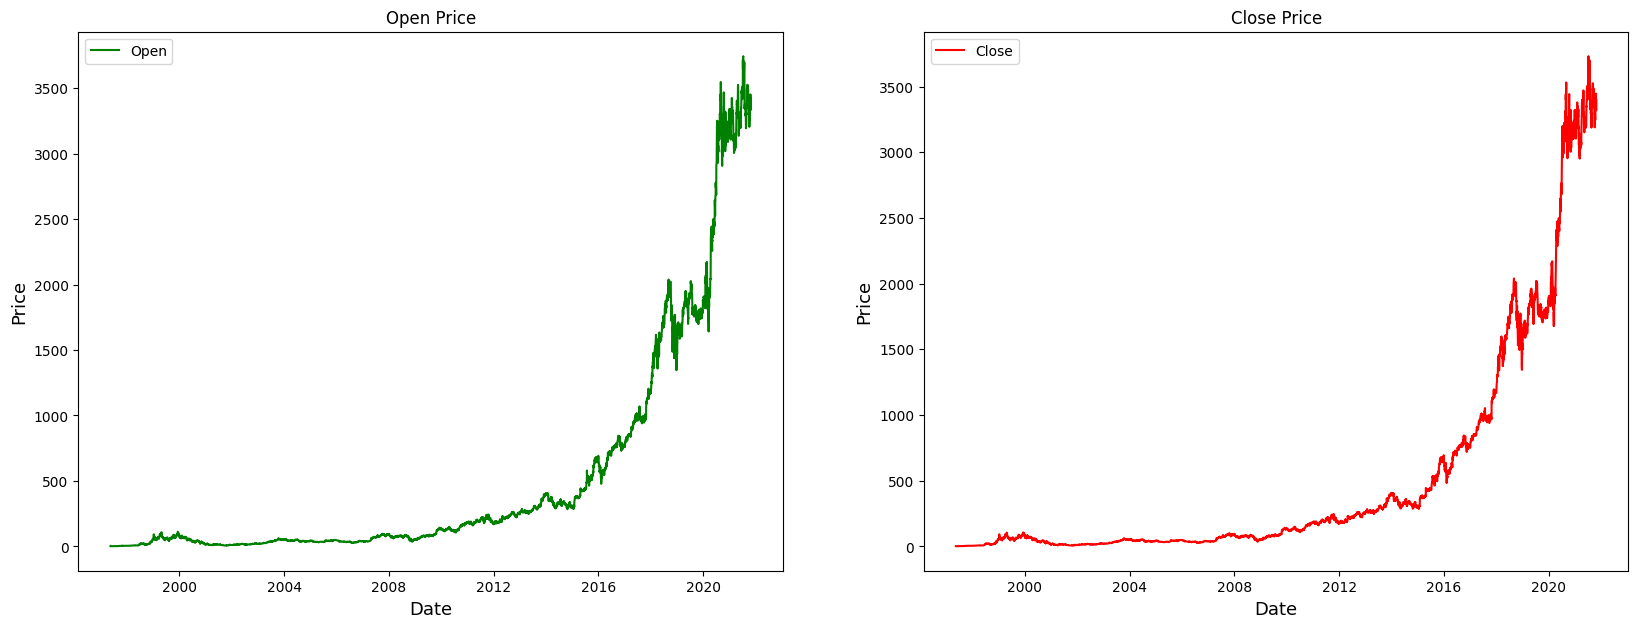

In [8]:
# Assuming df is your DataFrame
fig = plt.figure(figsize=(20, 7))

# Plotting open price
plt.subplot(1, 2, 1)
plt.plot(df['Open'], label='Open', color='green')
plt.xlabel('Date', size=13)
plt.ylabel('Price', size=13)
plt.title('Open Price')
plt.legend()

# Plotting closing price
plt.subplot(1, 2, 2)
plt.plot(df['Close'], label='Close', color='red')
plt.xlabel('Date', size=13)
plt.ylabel('Price', size=13)
plt.title('Close Price')
plt.legend()

plt.show()


### Data Preprocessing

In [9]:
# we'll normalizing all the values of all columns using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
df[df.columns] = mms.fit_transform(df)
df.head()

,Open,Close
Date,,
1997-05-15,0.000276,0.000151
1997-05-16,0.000150,0.000089
1997-05-19,0.000095,0.000084
1997-05-20,0.000086,0.000064
1997-05-21,0.000061,0.000008


### Split Training & Testing Data

In [10]:
#split data into Training and testing
training_size = round(len(df) * 0.8) #80% for training
training_size

4924

In [11]:
training_data = df[:training_size]
testing_data = df[training_size:]
training_data.shape, testing_data.shape

((4924, 2), (1231, 2))

In [12]:
# we'll create sequence of data for training and testing

def create_sequence(dataset):
    sequence = []
    labels = []

    start_idx = 0

    for stop_idx in range(50, len(dataset)): #selecting 50 rows at a time
        sequence.append(dataset.iloc[start_idx:stop_idx])
        labels.append(dataset.iloc[stop_idx])
        start_idx += 1
    return (np.array(sequence), np.array(labels))

In [13]:
train_seq, train_label, = create_sequence(training_data)
test_seq, test_label = create_sequence(testing_data)
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((4874, 50, 2), (4874, 2), (1181, 50, 2), (1181, 2))

### Create LSTM Model

In [14]:
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(train_seq.shape[1], train_seq.shape[2])),
    Dropout(0.15),
    LSTM(units=128, return_sequences=True),
    LSTM(units=64),
    Dense(2)
])

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           67072     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 248194 (969.51 KB)
Trainable params: 248194 (969.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# fitting the model by iterating the dataset over 50 times(50 epochs)
history = model.fit(x = train_seq,
                    y = train_label,
                    epochs = 50,
                    validation_data = (test_seq, test_label),
                    verbose = 1)

Epoch 1/50
153/153 [==============================] - 21s 23ms/step - loss: 1.0253e-04 - mean_absolute_error: 0.0047 - val_loss: 0.0044 - val_mean_absolute_error: 0.0471
Epoch 2/50
153/153 [==============================] - 2s 11ms/step - loss: 1.7518e-05 - mean_absolute_error: 0.0027 - val_loss: 0.0060 - val_mean_absolute_error: 0.0555
Epoch 3/50
153/153 [==============================] - 2s 12ms/step - loss: 1.4729e-05 - mean_absolute_error: 0.0025 - val_loss: 0.0032 - val_mean_absolute_error: 0.0393
Epoch 4/50
153/153 [==============================] - 2s 11ms/step - loss: 1.2052e-05 - mean_absolute_error: 0.0023 - val_loss: 0.0034 - val_mean_absolute_error: 0.0409
Epoch 5/50
153/153 [==============================] - 2s 12ms/step - loss: 1.1342e-05 - mean_absolute_error: 0.0023 - val_loss: 0.0015 - val_mean_absolute_error: 0.0275
Epoch 6/50
153/153 [==============================] - 2s 13ms/step - loss: 1.2163e-05 - mean_absolute_error: 0.0023 - val_loss: 0.0024 - val_mean_absolute

In [16]:
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mean_absolute_error']
val_mae=history.history['val_mean_absolute_error']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(mae)+1) # Get number of epochs

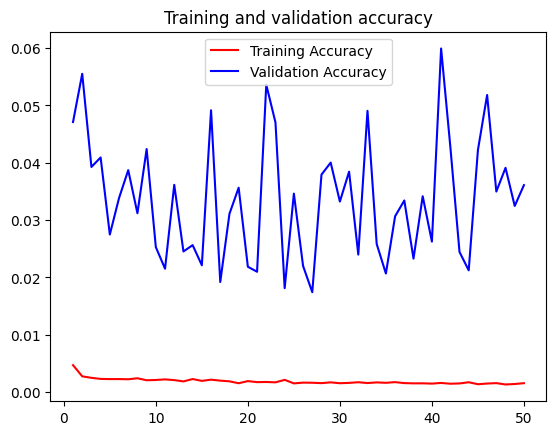

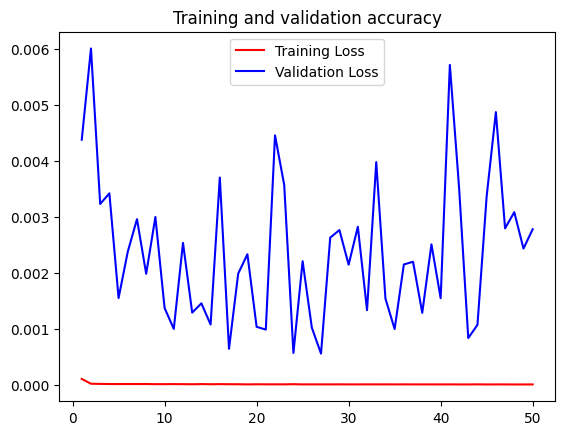

In [17]:
# Plot training and validation accuracy per epoch
plt.plot(epochs, mae, 'r')
plt.plot(epochs, val_mae, 'b')
plt.title('Training and validation accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation accuracy')
plt.legend(["Training Loss","Validation Loss"])
plt.show()

### Predicting the testing data

In [18]:
# predicting the values after running the model
test_predicted = model.predict(test_seq)
test_predicted[:5]

37/37 [==============================] - 1s 6ms/step


array([[0.22326581, 0.22467077],
       [0.22468007, 0.22603343],
       [0.22599038, 0.22733387],
       [0.22644372, 0.22779503],
       [0.2253721 , 0.22672036]], dtype=float32)

In [19]:
# Inversing normalization/scaling on predicted data
test_inverse_predicted = mms.inverse_transform(test_predicted)
test_inverse_predicted[:5]

array([[836.9995 , 839.42096],
       [842.2925 , 844.5037 ],
       [847.1965 , 849.3544 ],
       [848.8931 , 851.0745 ],
       [844.8825 , 847.066  ]], dtype=float32)

### PREDICTED DATA VS VISUALIZING ACTUAL

In [20]:
# Merging actual and predicted data for better visualization
df_merge = pd.concat([df.iloc[-test_label.shape[0]:].copy(),
                          pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],
                                       index=df.iloc[-test_label.shape[0]:].index)], axis=1)

In [21]:
# Inversing normalization/scaling
df_merge[['Open','Close']] = mms.inverse_transform(df_merge[['Open','Close']])
df_merge.head()

,Open,Close,open_predicted,close_predicted
Date,,,,
2017-02-21,848.840027,856.440002,836.999512,839.420959
2017-02-22,856.950012,855.609985,842.292480,844.503723
2017-02-23,857.570007,852.190002,847.196472,849.354370
2017-02-24,844.690002,845.239990,848.893127,851.074524
2017-02-27,842.380005,848.640015,844.882507,847.065979


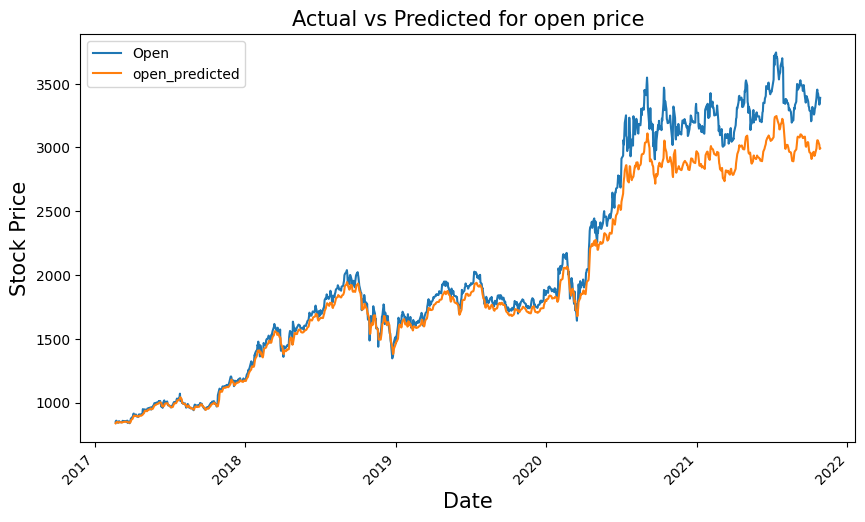

In [22]:
# plotting the actual open and predicted open prices on date index
df_merge[['Open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

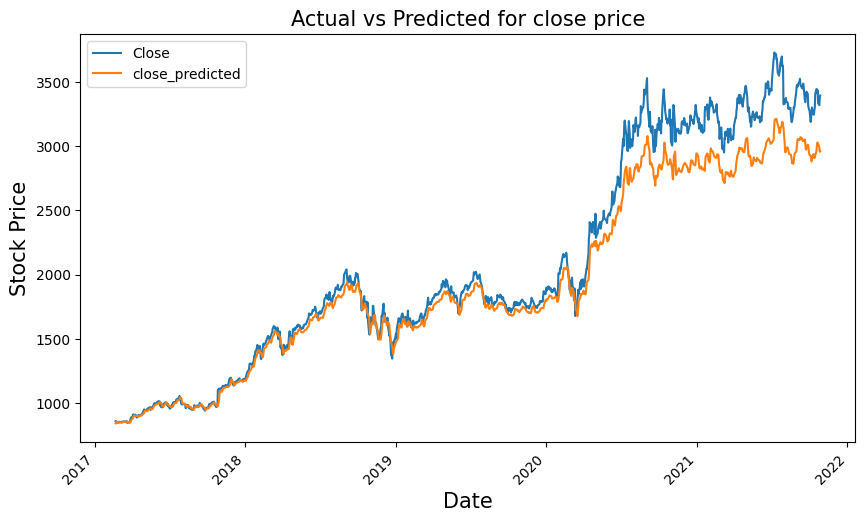

In [23]:
# plotting the actual close and predicted close prices on date index
df_merge[['Close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

### PREDICTING UPCOMING 20 DAYS

In [24]:
# Creating a dataframe and adding 10 days to existing index

df_merge = df_merge.append(pd.DataFrame(columns=df_merge.columns,
                                        index=pd.date_range(start=df_merge.index[-1], periods=11, freq='D', closed='right')))
df_merge['2021-03-25':'2021-04-14']

,Open,Close,open_predicted,close_predicted
2021-03-25,3072.989990,3046.260010,2832.529297,2809.683594
2021-03-26,3044.060059,3052.030029,2805.165039,2783.035400
2021-03-29,3055.439941,3075.729980,2784.180420,2761.542725
2021-03-30,3070.010010,3055.290039,2785.450439,2762.046387
2021-03-31,3064.060059,3094.080078,2788.127441,2764.825195
2021-04-01,3117.939941,3161.000000,2799.106934,2776.173584
2021-04-05,3173.000000,3226.729980,2832.030029,2809.357910
2021-04-06,3223.750000,3223.820068,2875.319336,2853.091553
2021-04-07,3233.800049,3279.389893,2901.344482,2879.687988
2021-04-08,3310.899902,3299.300049,2922.985107,2900.994629


We observe that there is less than 20 days data, we will visualize on them

In [25]:
# creating a DataFrame and filling values of open and close column
upcoming_prediction = pd.DataFrame(columns=['Open','Close'],index=df_merge.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [26]:
curr_seq = test_seq[-1:]

for i in range(-14,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)

1/1 [==============================] - 0s 21ms/step


In [27]:
# inversing Normalization/scaling
upcoming_prediction[['Open','Close']] = mms.inverse_transform(upcoming_prediction[['Open','Close']])

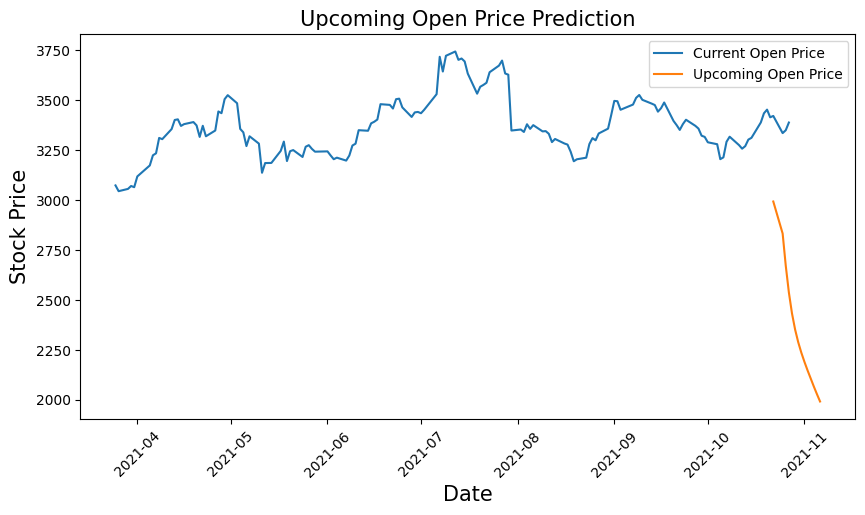

In [28]:
# Plotting Current and Upcoming Open Prices
plt.figure(figsize=(10, 5))
plt.plot(df_merge.loc['2021-03-25':, 'Open'], label='Current Open Price')
plt.plot(upcoming_prediction.loc['2021-04-14':, 'Open'], label='Upcoming Open Price')

# Setting labels, title, and legend
plt.xlabel('Date', size=15)
plt.ylabel('Stock Price', size=15)
plt.title('Upcoming Open Price Prediction', size=15)
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.show()


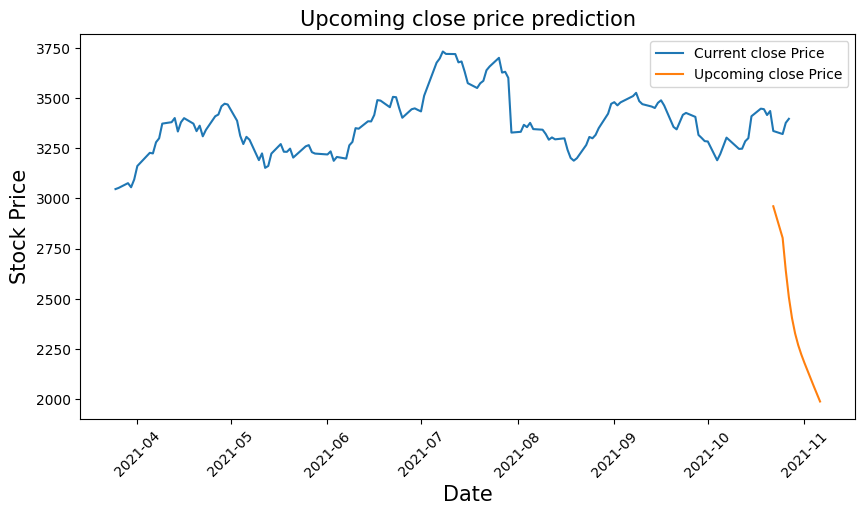

In [29]:
# plotting Upcoming Close price on date index
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(df_merge.loc['2021-03-25':,'Close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2021-04-14':,'Close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fig.show()

# Thank You!

#### by Ashutosh Singh Thakur